# Getting started with LLMs

# Setup

Most of the time, you will interact with LLMs via an API.
OpenAI has an API standard that's been adopted by most other LLM providers.
Today, we'll be using `litellm`, a package that wraps multiple LLM providers with a common interface.

In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
# Imports
from ctme.utils import get_root_dotenv
import os
from rich import print

In [6]:
env_path = get_root_dotenv(load=True)

expected_variables = [
    "GEMINI_API_KEY",
    "OPENROUTER_API_KEY"
]

assert any([os.getenv(e) for e in expected_variables]),  f"Expect at one of {expected_variables} to be populated"

# The basics

Let's start by using the LLM `gemini-2.0-flash`'s free tier to learn about how to query LLMs.

In the cell below 👇, we import `completion` from `litellm`.
This is the core function we'll be using to chat with models in this section.

## Making requests

This model happens to be trained for chat.
Chat expects a `list` of messages.
Each message is a dictionary with a `role` field specifying the type of message, and a `content` field specifying the content of the message.
Three `role` values are supported:

- `system`, for giving general instructions to the LLM for how to behave
- `user`, for a user message, and
- `assistant`, for the LLM's response.

Let's give the LLM a simple prompt and see what it returns.

In [7]:
from litellm import completion, acompletion

In [8]:
GEMINI_MODEL = 'gemini/gemini-2.0-flash'

In [11]:
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Reverse the following string: 'abcde'. Let's think step by step:"},
]
response = completion(model=GEMINI_MODEL, messages=messages)
print(response)

ModelResponse(
    id='chatcmpl-b380b206-4287-447c-9d14-955441e619fd',
    created=1747511029,
    model='gemini-2.0-flash',
    object='chat.completion',
    system_fingerprint=None,
    choices=[
        Choices(
            finish_reason='stop',
            index=0,
            message=Message(
                content='Okay, let\'s reverse the string "abcde" step by step:\n\n1.  **Identify the string:** We 
have the string "abcde".\n2.  **Determine the length:** The string has a length of 5 characters.\n3.  **Reverse the
order:** We need to rearrange the characters in the opposite order. The last character (\'e\') becomes the first, 
the second-to-last (\'d\') becomes the second, and so on.\n4.  **Construct the reversed string:**  Following the 
reversed order, the string becomes "edcba".\n\nSo, the reversed string is "edcba".\n',
                role='assistant',
                tool_calls=None,
                function_call=None,
                provider_specific_fields=None
            )
        )
    ],
    usage=Usage(
        completion_tokens=134,
        prompt_tokens=23,
        total_tokens=157,
        completion_tokens_details=None,
        prompt_tokens_details=PromptTokensDetailsWrapper(
            audio_tokens=None,
            cached_tokens=None,
            text_tokens=23,
            image_tokens=None
        )
    ),
    vertex_ai_grounding_metadata=[],
    vertex_ai_safety_results=[],
    vertex_ai_citation_metadata=[]
)

The response actually has a lot of useful information.
It has the model, a timestamp, other identifiers, and model-specific metadata like safety ratings in several different capacities.
But the real content is in the `choices` field.
Currently, the `choices` field only has one element containing the message returned by the LLM.
Let's access the LLM's response:

In [12]:
print(response.choices[0].message.content)

Okay, let's reverse the string "abcde" step by step:

1.  **Identify the string:** We have the string "abcde".
2.  **Determine the length:** The string has a length of 5 characters.
3.  **Reverse the order:** We need to rearrange the characters in the opposite order. The last character ('e') 
becomes the first, the second-to-last ('d') becomes the second, and so on.
4.  **Construct the reversed string:**  Following the reversed order, the string becomes "edcba".

So, the reversed string is "edcba".

## Extending the chat history

In a chat setting, we also want to persist the response so we can continue the chat.
we can add it to the `messages` so we can ask a new question in the same dialog, assuming we want to create a message history.

In [14]:
assistant_message = response.choices[0].message.model_dump() # convert the last assistant message to a dictionary
messages.append(assistant_message) # append to the messages
print(assistant_message)

{
    'content': 'Okay, let\'s reverse the string "abcde" step by step:\n\n1.  **Identify the string:** We have the 
string "abcde".\n2.  **Determine the length:** The string has a length of 5 characters.\n3.  **Reverse the order:**
We need to rearrange the characters in the opposite order. The last character (\'e\') becomes the first, the 
second-to-last (\'d\') becomes the second, and so on.\n4.  **Construct the reversed string:**  Following the 
reversed order, the string becomes "edcba".\n\nSo, the reversed string is "edcba".\n',
    'role': 'assistant',
    'tool_calls': None,
    'function_call': None
}

Since the whole history of messages is in-context and passed to the LLM, it can perform logical extensions of the original task as seen here:

In [15]:
new_message = {'role': 'user', 'content': "Now reverse it back to the same order."}
messages.append(new_message)

response = completion(model=GEMINI_MODEL, messages=messages)
print(response.choices[0].message.content)

Okay, let's reverse the string "edcba" back to its original order:

1. **Identify the string:** We have the string "edcba".
2. **Determine the length:** The string has a length of 5 characters.
3. **Reverse the order:** We need to rearrange the characters in the opposite order. The last character ('a') 
becomes the first, the second-to-last ('b') becomes the second, and so on.
4. **Construct the reversed string:** Following the reversed order, the string becomes "abcde".

So, the reversed string is "abcde".

## Streaming responses

Another popular feature is streaming.
Since we're generating 1 token at a time, the API can also return text as it's generated.
This can be extra useful when you have long responses, and is nice in a user interface.

In [16]:
# streaming
response = completion(model=GEMINI_MODEL, messages=messages, stream=True)
for chunk in response:
    print(chunk.choices[0].delta.content, end='')

Okay

, let'

s reverse "edcba" back to its original order:

1. **Identify

the string:** We have the string "edcba".
2. **

Determine the length:** The string has a length of 5 characters.
3. **Reverse the order:**  We need to rearrange the characters in the opposite order. The

last character ('a') becomes the first, the second-to-last ('b') becomes the second, and so on.
4. **Construct the

reversed string:** Following the reversed order, the string becomes "abcde".

Therefore, reversing "edcba" results in "abcde".

None

## Async responses

When we make API calls to these models, the time it takes to make a request is relatively short but the inference time can be long.
Calling these APIs asynchronously lets us do other things while we're waiting for a response.
Without async, we are waiting for the first API call to be complete to begin making the second call.
Using async, we can make all the calls and `await` responses as they come in.

Here's an example of an async request 👇

In [17]:
# async
response = await acompletion(model=GEMINI_MODEL, messages=messages)
print(response.choices[0].message.content)

Okay, let's reverse "edcba" back to its original order, step by step:

1. **Identify the string:** We have the string "edcba".
2. **Determine the length:** The string has a length of 5 characters.
3. **Reverse the order:**  We need to rearrange the characters in the opposite order again. The last character 
('a') becomes the first, the second-to-last ('b') becomes the second, and so on.
4. **Construct the reversed string:** Following the reversed order, the string becomes "abcde".

So, the reversed string is "abcde".

Now, let's demonstrate that we can make multiple simultaneous requests with async than we can with blocking requests.

In [21]:
import time
# With blocking requests
start = time.time()
for i in range(5):
    print(f"Making request {i}")
    response = completion(model=GEMINI_MODEL, messages=messages)
total_seconds = time.time() - start
print(f'Total time: {total_seconds} seconds')

Making request 0

Making request 1

Making request 2

Making request 3

Making request 4

Total time: 5.400669813156128 seconds

In [22]:
import asyncio
async def _acomplete(model, messages, i):
    print(f"Making request {i}")
    response = await acompletion(model=model, messages=messages)
    return response.choices[0].message.content

start = time.time()
tasks = [_acomplete(GEMINI_MODEL, messages, i) for i in range(5)]
responses = await asyncio.gather(*tasks)
total_seconds = time.time() - start
print(f'Total time: {total_seconds} seconds')

/var/folders/jp/0p2866g148b4kyr110gn7x2r0000gn/T/ipykernel_85123/2466043737.py:8: RuntimeWarning: coroutine '_acomplete' was never awaited
  tasks = [_acomplete(GEMINI_MODEL, messages, i) for i in range(5)]


Making request 0

Making request 1

Making request 2

Making request 3

Making request 4

Total time: 1.1553678512573242 seconds

##  Exercise 1: Simple chatbot

So far, we've gone over how to make basic API calls using a Python SDK.
Let's put what we've learned to use and make a basic chatbot using the popular `gradio` library.
All we have to do is define a function for that handles a user message and extends the chat history.
Documentation on `gradio.ChatInterface` can be found [here](https://www.gradio.app/guides/creating-a-chatbot-fast).
Follow this guide to make a chatbot.

**Bonus**: figure out how to add a system prompt and stream resopnses.

In [ ]:
system_prompt = "You are a helpful assistant that always answers in pirate speak."

def chat(message:str, history) -> str:
    if not len(history):
        history.append({'role': 'system', 'content': system_prompt})
    history.append({'role': 'user', 'content': message})
    response = completion(model=GEMINI_MODEL, messages=history, stream=True)
    to_return = ""
    for chunk in response:
        if chunk.choices[0].delta.content is not None:
            to_return += chunk.choices[0].delta.content
            yield to_return

gr.ChatInterface(chat, type='messages').launch()

# Generation hyperparameters

Each model has different supported hyperparameters.
Let's evaluate the hyperparameters here and get a good feeling for what they do.
`litellm` has a handy function to tell us what parameters the model expects.

In [ ]:
get_supported_openai_params(model=GEMINI_MODEL)

## `temperature`

Let's recall that temperature alters the softmax function to skew the probability distribution of tokens during decoding.
To illustrate, let's look at the interactive plot below 👇.
We have a small probability distribution representing the top probabilities at a single decoding step.
There are 5 tokens, `A`, `B`, `C`, `D`, and `E`, where `A` is the most probable with a score of 0.5 and `D` and `E` are at the bottom with a score of 0.05.

## Exercise 2: `softmax_with_temperature` visualization

Please fill in the `softmax_with_temperature` function.
Since we're not doing any backpropagation, let's use `numpy`.

The softmax with temperature function is as follows:

$\text{softmax}(p, T) = \frac{\exp\left(\frac{\log(p_i)}{T}\right)}{\sum_{j}
\exp\left(\frac{\log(p_j)}{T}\right)}$

Where:
- $p_i$  represents the original probability values.
- $T$  is the temperature parameter.
- $\exp$  is the exponential function.

Once you've implemented the python function, run the cell and play with the widget.
If temperature is smaller, how do you think that will affect text generation?
What about when temperature is large?
Most LLM providers cap temperature at 2.0.
Why might you do this?

In [ ]:
# Define a small probability distribution
probs = np.array([0.5, 0.3, 0.1, 0.05, 0.05])

# Softmax function with temperature parameter
def softmax_with_temperature(probs, temperature):
    exp_probs = np.exp(np.log(probs) / temperature)
    return exp_probs / np.sum(exp_probs)

# Plot the distribution with numbers on top of each bar
def plot_distribution(temperature):
    adjusted_probs = softmax_with_temperature(probs, temperature)
    plt.figure(figsize=(6, 4))
    bars = plt.bar(range(len(probs)), adjusted_probs, tick_label=['A', 'B', 'C', 'D', 'E'])
    plt.ylim(0, 1)
    plt.title(f'Softmax with Temperature = {temperature:.2f}')
    plt.ylabel('Probability')
    plt.xlabel('Categories')

    # Add numbers on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

    plt.show()

# Interactive widget
interact(plot_distribution, temperature=(0.1, 2.0, 0.1));

Now that we've got a good feeling for what `temperature` does to the probability distribution, let's examine some of the outputs.
In addition to qualitatively observing the outputs, we will calculate the similarity between each pair of generations using `fuzzywuzzy`, a library that calculates similarity using levenshtein distance.
Roughly, it's based on the number of characters we'd have to change to turn string 1 into string 2.
100 is exact match, and 0 is no match.


In [ ]:
# perfect match, 50% matc, 0 match
fuzz.ratio('a', 'a'), fuzz.ratio('ab', 'bb'), fuzz.ratio('a', 'b')

In [18]:
messages = [
    {'role': 'user', 'content': 'write a limerick about python'}
]

In [ ]:
contents = []
for choice in completion(model=GEMINI_MODEL, messages=messages, temperature=0, n=5).choices:
    content = choice.message.content
    contents.append(content)
combos = combinations(contents, 2)
ratios = [fuzz.ratio(c1, c2) for c1, c2 in combos]
print(f"Average text similarity (fuzz.ratio): {np.mean(ratios)}")
for c in contents:
    print(c)
    print('='*40)

In [ ]:
contents = []
for choice in completion(model=GEMINI_MODEL, messages=messages, temperature=1.9, n=5).choices:
    content = choice.message.content
    contents.append(content)
combos = combinations(contents, 2)
ratios = [fuzz.ratio(c1, c2) for c1, c2 in combos]
print(f"Average text similarity (fuzz.ratio): {np.mean(ratios)}")
for c in contents:
    print(c)
    print('='*40)

## `top_p` (nucleus sampling)

Let's re-visit top-p sampling.
We definie the cumulative sum of the probabilitity distribution we want to allow for decoding.
Let's formally define it:


$\text{Top-p sampling:} \quad P(S) = \{x_i \mid \sum_{x_j \in S} P(x_j) \geq p \}$

Where:

- $P(x_i)$  is the probability of token  x_i .
- $S$  is the set of selected tokens.
- $p$  is the cumulative probability threshold (top-p value).

In short, we take the set of all tokens such that the sum of the token probabilities is greater than or equal to the parameter $p$.
Let's illustrate this in anoher widget.


In [ ]:
# Define a small probability distribution (can simulate a language model's logits)
probs = np.array([0.4, 0.2, 0.15, 0.1, 0.08, 0.05, 0.02])

# Function to apply top-p filtering with a minimum of one token selected
def top_p_filter(probs, p):
    sorted_probs = np.sort(probs)[::-1]
    cumulative_probs = np.cumsum(sorted_probs)

    # Ensure at least one token is selected
    if p < sorted_probs[0]:
        cutoff = 1
    else:
        cutoff = np.argmax(cumulative_probs >= p) + 1

    filtered_probs = sorted_probs[:cutoff]
    return filtered_probs, cutoff

# Plot the distribution with top-p filtering
def plot_top_p(p):
    filtered_probs, cutoff = top_p_filter(probs, p)
    normalized_probs = filtered_probs / np.sum(filtered_probs)  # Normalize the selected probabilities

    # Create two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

    # Plot 1: Original distribution with top-p filtering
    bars1 = axs[0].bar(range(len(probs)), np.sort(probs)[::-1], tick_label=labels)
    axs[0].set_ylim(0, 1)
    axs[0].set_title(f'Top-p Sampling (p = {p:.2f}) - Original Probabilities')
    axs[0].set_ylabel('Probability')
    axs[0].set_xlabel('Categories')

    # Highlight selected and unselected probabilities
    for i, bar in enumerate(bars1):
        if i >= cutoff:
            bar.set_color('gray')  # Color the bars outside top-p as gray
        else:
            bar.set_color('blue')  # Highlight the selected probabilities

    # Add numbers on top of each bar for original distribution
    for bar in bars1:
        yval = bar.get_height()
        axs[0].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

    # Plot 2: Normalized probabilities of the selected tokens
    bars2 = axs[1].bar(range(len(filtered_probs)), normalized_probs, tick_label=labels[:len(filtered_probs)])
    axs[1].set_ylim(0, 1)
    axs[1].set_title(f'Normalized Probabilities of Selected Tokens (p = {p:.2f})')
    axs[1].set_ylabel('Normalized Probability')
    axs[1].set_xlabel('Selected Categories')

    # Add numbers on top of each bar for normalized probabilities
    for bar in bars2:
        yval = bar.get_height()
        axs[1].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Interactive widget
interact(plot_top_p, p=(0.01, 1.0, 0.05));

## Exercise 3: Relationship between `top_p` and sequence similarity

Just like `temperature`, `top_p` is another lever to control how text is generated.
I this exercise, let's actually visualize that relationship.
Please create a plot wher the x-axis is the `top-p` value, and the y-axis is the average similarity (using `fuzz.ratio`) of all of the generations for the same prompt.

In [ ]:
results = []
# Create a range of p values
ps = np.arange(0.1,1.1,.1)
# For each p...
results = []
for p in ps:
    # Generate 5 choices at that top p
    contents = []
    for choice in completion(model=GEMINI_MODEL, messages=messages, top_p=p, n=5).choices:
        content = choice.message.content
        contents.append(content)
    # Make combinations of each pair of contents
    combos = combinations(contents, 2)
    # Calculate the ratio of each of those combinations
    ratios = [fuzz.ratio(c1, c2) for c1, c2 in combos]
    for r in ratios:
        results.append(dict(top_p=p, ratio=r))
results = pd.DataFrame(results)

sns.lineplot(x='top_p', y='ratio', data=results)

# Structured outputs

Many times, we want to use LLMs as middleware in other systems.
That means they may have to do things like extract structured data, populate parameters to API calls, etc.
This is really hard to do with plain text LLM responses - you have to do lots of "begging" to get the LLM to output a consistent structure.

For this next section, we're going to switch to OpenAI's API since it's much better than gemini at producing structured outputs.
We will be using `gpt-4o-mini`.

The most convenient way to declare what you want to return is with `pydantic` models.
These are really useful because you can define exactly the values, formats, and types you expect back.
As you can see in the `EventDetails` class below, we've specified all the information we want to know about an event.
We can even describe complex objects, like lists or dicts of other objects.

In [28]:
OPENAI_MODEL = 'openai/gpt-4o-mini'

In [41]:
class EventDetails(BaseModel):
    attendees: List[str] = Field(..., description="List of attendees")
    date: Optional[str] = Field(..., description="Date of the event, in the YYYY-MM-DD format")
    eventName: str = Field(..., description="Name of the event")

In [44]:
text = "Jan and Peter are going to have dinner"
resp = completion(
    model=OPENAI_MODEL,
    messages=[
        {'role': 'system', 'content': f"Today's date is {date.today()}. Do not include any information not in the message."},
        {"role": "user", "content": text}
        ],
    response_format=EventDetails)

In [ ]:
print("Response text:\n", c:=resp.choices[0].message.content)
print("Loaded JSON:", j:=json.loads(c))
print("Pydantic object:", o:=EventDetails(**j))

# Function calling

In [ ]:
print(f"{GEMINI_MODEL} supports function calling: ", litellm.supports_function_calling(model=GEMINI_MODEL))
print(f"{OPENAI_MODEL} supports function calling: ", litellm.supports_function_calling(model=OPENAI_MODEL))

In [47]:
def get_stock_data(
        symbols:Union[str, List[str]],
        start_date:Optional[str]=str(date.today() - timedelta(days=7)),
        end_date:Optional[str] = str(date.today())
):
    result = yf.download(symbols, start=start_date, end=end_date)
    return result.to_markdown()

In [ ]:
display(Markdown(get_stock_data('MSFT')))

In [51]:
function_definition = {
    "type": "function",
    "function": {
        "name": "get_stock_data",
        "description": "Get historical stock data for a symbol or list of symbols. Returns markdown table.",
        "parameters": {
            "type": "object",
            "properties": {
                "symbols": {
                    "type": "string",
                    "description": "Symbol or list of symbols to get data for",
                    "required": ["symbols"]
                    },
                "start_date": {
                    "type": "string",
                    "description": "Start date in YYYY-MM-DD format. Should be at least 1 day before the end_date.",
                },
                "end_date": {
                    "type": "string",
                    "description": "End date in YYYY-MM-DD format",
                }
            },
            "required": ["symbols"]
        }
    }
}
functions = [function_definition]

In [56]:
messages = [{"role": "user", "content": f"What's the most recent week's high and low for MSFT? Today's date is {date.today()}."}]
resp = completion(
    model=OPENAI_MODEL,
    messages=messages,
    tools=functions,
    tool_choice='auto'
)

In [ ]:
message = resp.choices[0].message
message

In [ ]:
tool_call = message.tool_calls[0]
tool_call

In [ ]:
func = tool_call.function.name
args = json.loads(tool_call.function.arguments)
output_str = eval(f"{func}(**{args})")
display(Markdown(output_str))

In [61]:
messages.append(message.dict())
messages.append(
    {
        "tool_call_id": tool_call.id,
        "role": "tool",
        "name": func,
        "content": output_str,
    }
)

In [ ]:
print(messages)

In [63]:
resp = completion(
    model=OPENAI_MODEL,
    messages=messages
)

In [ ]:
print(resp.choices[0].message.content)

## Exercise 4: Fix this stock retriever

Do you notice anything weird about the response here?
LLMs have a knowledge cutoff, meaning that they don't know anything after a certain date.
To solve this, we need to give the LLM the current date.
What are some ways to do this?
Please edit the above code to fix the error.

# High-level frameworks: `llama-index`

So far, we've been working with the pretty basic OpenAI API specification.
It's really good to have experience with this because it's a pretty universal API standard.
However, sometimes it can take a lot of time to write certain functionalities such as structured outputs, function calls, etc.
They're not a panacea, but high-level LLM libraries can really help take some of the gruntwork out of working with LLMs.

In this couse, we'll be using [`llama-index`](https://docs.llamaindex.ai/en/stable/) as our high-level library, but there are other popular options like `langchain` and `DSPy`.

Let's start by replicating some of the text generation we did previously.

In [65]:
openai_llm = OpenAI(model='gpt-4o-mini')
gemini_llm = Gemini(model='models/gemini-1.5-flash-002')

## Generate text

Text generation using `llama-index` is pretty straightforward.
Once you've created an instance of an LLM object, you can call `.complete`, `chat`, `acomplete`, or `achat` directly on the object.

In [66]:
messages = [
    ChatMessage(role='user', content='Write a limerick about python')
]

In [68]:
# resp = openai_llm.chat(messages=messages, n=5, top_p=0.9, temperature=0.9) # sync
resp = await openai_llm.achat(messages=messages, n=5, top_p=0.9, temperature=0.9) # async

In [ ]:
for c in resp.raw.choices:
    print(c.message.content)
    print('='*40)

## Generate structured outputs

Structured outputs are much the same - you define a `pydantic` object, and instruct the LLM to generate that object.
Here, we're going to get a bit more complex with the pydantic objects we're creating.

In [70]:
class Person(BaseModel):
    name: str = Field(..., description="Name of the person")
    age: int = Field(..., description="Age of the person", ge=1, le=100)

class People(BaseModel):
    people: List[Person] = Field(..., description="List of people")

message = ChatMessage.from_str('Please create 3 people')

structured_llm = openai_llm.as_structured_llm(output_cls=People)

structured_output = structured_llm.chat([message])

In [ ]:
structured_output

In [ ]:
structured_output.raw

## Call functions

Calling functions can also be easier with frameworks.
If you still want to use tools like `litellm`, high-level frameworks can still make life a bit easier by creating that nasty function json for you.
You can also use them to call functions.
Tomorrow when we work with agents, we will be using even more advanced function calling usage.

In [73]:
def get_stock_data(
        symbols:Union[str, List[str]] = Field(..., description="Symbol or list of symbols"),
        start_date:Optional[str] = Field(default=str(date.today() - timedelta(days=7)), description="Start date in YYYY-MM-DD format. Should be at least 1 day before the end_date."),
        end_date:Optional[str] = Field(default=str(date.today()), description="End date in YYYY-MM-DD format")
):
    """
    Get historical stock data for a symbol or list of symbols. Returns markdown table.

    Args:
        symbols (Union[str, List[str]]): Symbol or list of symbols to get data for.
        start_date (Optional[str], optional): Start date in YYYY-MM-DD format. Defaults to 7 days before today. Must be at least 1 day before end_date.
        end_date (Optional[str], optional): End date in YYYY-MM-DD format. Defaults to today. Must be at least 1 day after start_date.
    """
    result = yf.download(symbols, start=start_date, end=end_date)
    return result.to_markdown()

In [80]:
llama_index_function = FunctionTool.from_defaults(fn=get_stock_data)

In [ ]:
# llama_index_function.as_o

In [81]:
message = ChatMessage.from_str(f"What's the most recent week's high and low for MSFT? Today's date is {date.today()}.")
resp = openai_llm.chat_with_tools([llama_index_function], user_msg=message)

In [ ]:
print(resp)

In [ ]:
fn_args = json.loads(resp.raw.choices[0].message.tool_calls[0].function.arguments)
fn_args

In [ ]:
display(Markdown(get_stock_data(**fn_args)))

# Practicum: Generate an ecommerce DB

### Problem statement:

You are helping an immaginary online retailer build an customer support agent.
But they don't want to share any of their data with you, only the schema of their database.
We need to create some reasonable data for a proof of concept.
Over the next several days, we will be using this data to build a customer support agent.


### Generating the data

Use what you've learned about generating structured data to help fill the following tables.
When we're done, your database should contain:
* Generate 10-20 customers in the `customers` table
* Generate 50 products in the `items` table
* A purchase history for each customer ranging from 1 to 10 items in the `orders` table

Remember to think critically about what the llm *should* and *should not* generate.
One example is IDs - we've gone ahead and created database tables with auto-incrementing IDs.

Below, we have code to create the tables, as well as an example of how to add data to the tables using `df.to_sql`.

In [95]:
import sqlite3

from sqlalchemy import create_engine

In [96]:
def create_tables():
    if os.path.exists('ecommerce.db'):
        os.remove('ecommerce.db')
    conn = sqlite3.connect('ecommerce.db')
    cursor = conn.cursor()

    # Create Customers Table
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS customers (
            customer_id INTEGER PRIMARY KEY AUTOINCREMENT,
            name TEXT NOT NULL,
            email TEXT UNIQUE NOT NULL,
            phone TEXT,
            street_address TEXT,
            city TEXT,
            state TEXT,
            zip_code TEXT,
            country TEXT,
            account_status TEXT,
            pin TEXT
        );
    """)

    # Create Items Table
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS items (
            item_id INTEGER PRIMARY KEY AUTOINCREMENT,
            name TEXT NOT NULL,
            description TEXT,
            price REAL NOT NULL,
            quantity INTEGER NOT NULL
        );
    """)

    # Create Orders Table
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS orders (
            order_id INTEGER PRIMARY KEY AUTOINCREMENT,
            customer_id TEXT NOT NULL,
            item_id TEXT NOT NULL,
            status TEXT,
            ordered_date TEXT,
            estimated_delivery TEXT,
            shipping_carrier TEXT,
            tracking_number TEXT,
            shipping_address TEXT,
            FOREIGN KEY (customer_id) REFERENCES customers(customer_id),
            FOREIGN KEY (item_id) REFERENCES items(item_id)
        );
    """)

    conn.commit()
    conn.close()
    print("Tables created successfully.")

In [97]:
def query(sql:str) -> pd.DataFrame:
    conn = sqlite3.connect('ecommerce.db')
    cursor = conn.cursor()
    cursor.execute(sql)
    results = cursor.fetchall()
    columns = [column[0] for column in cursor.description]
    conn.close()
    return pd.DataFrame(results, columns=columns)

def execute(sql:str) -> None:
    conn = sqlite3.connect('ecommerce.db')
    cursor = conn.cursor()
    cursor.execute(sql)
    conn.commit()
    conn.close()

In [ ]:
create_tables()
engine = create_engine('sqlite:///ecommerce.db')
one_customer = pd.DataFrame([
    {
        'name': 'mike',
        'email': 'mike@gmail.com',
        'phone': '555-555-5555',
        'street_address': '123 Main St',
        'city': 'Anytown',
        'state': 'CA',
        'zip_code': '12345',
        'country': 'USA',
        'account_status': 'active',
        'pin': '1234'
    }
])

one_customer.to_sql('customers', engine, if_exists='append', index=False)

query('SELECT * FROM customers')

In [ ]:
create_tables()

## Generate 10-20 customers

Use this section to practice creating structured outputs with the `openai_llm` or `gemini_llm` object we created earlier.
Use `pydantic` to define the schema of the data you want to generate, then use an LLM to generate them.
Once you generate your customers, insert them into the database.
Make sure that the values you're generating make sense!

**NOTE:** If you perform multiple LLM calls to generate customers, make sure you are not generating the same customers.
Some LLM providers will cache responses, so the same prompt will give you the same output.

In [103]:
customer_statuses = Literal['active', 'inactive', 'suspended', 'canceled']

class Customer(BaseModel):
    name: str = Field(..., description="Name of the customer")
    email: str = Field(..., description="Email of the customer")
    phone: str = Field(..., description="Phone number of the customer")
    street_address: str = Field(..., description="Street address of the customer")
    city: str = Field(..., description="City of the customer")
    state: str = Field(..., description="State of the customer (US Only)")
    zip_code: str = Field(..., description="Zip code of the customer")
    country: str = Field(default='US', description="Country of the customer")
    account_status: customer_statuses = Field(..., description="Status of the customer account")
    pin: str = Field(default_factory=lambda x: f"{np.random.randint(0, 1000):04}", description="PIN for the customer")

class Customers(BaseModel):
    customers: List[Customer] = Field(..., description="List of customers")

In [104]:
customers = []
prompt = "Please generate 5 customers from random cities in the US"
messages = [ChatMessage.from_str(prompt)]
structured_llm = openai_llm.as_structured_llm(output_cls=Customers)
resp = structured_llm.chat(messages)
for c in resp.raw.customers:
    customers.append(c.model_dump())
for _ in range(3):
    messages.append(resp.message)
    messages.append(ChatMessage.from_str("Please generate 5 more customers"))
    resp = structured_llm.chat(messages)
    for c in resp.raw.customers:
        customers.append(c.model_dump())

In [ ]:
customer_df = pd.DataFrame(customers)
customer_df.sample(5)

In [ ]:
engine = create_engine('sqlite:///ecommerce.db')
customer_df.to_sql('customers', engine, if_exists='append', index=False)

In [ ]:
query('SELECT * FROM customers ORDER BY random() LIMIT 5;')

## Generate 50 products/items

Let's take a slightly different approach.
Another way to generate structured outputs with `llama-index` is using the LLM pydantic program.
Please read the documentation [here](https://docs.llamaindex.ai/en/stable/examples/output_parsing/llm_program/) and use `LLMTextCompletionProgram` to create data to populate the `items` table.

**Hint:** Use the pydantic's `Field` to set some sensible defaults.
You can set parameters like `ge` (greater than or equal to) or `le` (less than or equal to), or `default_factory` to use a function to generate default values.

In [108]:
class Item(BaseModel):
    name: str = Field(..., description="Name of the item")
    description: str = Field(..., description="A 3-4 sentence paragraph of text describing the item.")
    price: float = Field(..., description="Price of the item")
    quantity: int = Field(default_factory=lambda x: np.random.randint(0, 50), description="Quantity of the item in stock", ge=0, le=50)

class Items(BaseModel):
    items: List[Item] = Field(..., description="List of items")

In [ ]:
structured = openai_llm.as_structured_llm(output_cls=Items)
items = []
messages = [
    ChatMessage.from_str("Please create 10 electronics items.")
]
resp = structured.chat(messages)
items.extend(resp.raw.items)
for _ in range(4):
    print(_)
    messages.append(resp.message)
    messages.append(ChatMessage.from_str("Please create 10 more items."))
    resp = structured.chat(messages)
    items.extend(resp.raw.items)

In [122]:
items_df = pd.DataFrame([i.model_dump() for i in items])

In [ ]:
engine = create_engine('sqlite:///ecommerce.db')
items_df.to_sql('items', engine, if_exists='append', index=False)

In [ ]:
query('SELECT * FROM items ORDER BY random() LIMIT 5;')

## Order history

Now let's generate the order history for each customer.
Since we will have many orders per customer, we are potentially generating hundreds of orders.
This is a time when we want to use async processing.
For each customer, please generate between 0 and 20 orders using `acall` (`LLMTextCompletionProgram`) or `achat` (structured LLM).

Try to think about typical patterns you'd see in ordering.
For example, customers are probably shipping to themselves *most* of the time, but sometimes buy items shipped to a work address or to a friend's home as a gift.
Think about what information you can pull from the database and what should be generated by the LLM to help set some sensible defaults.

In [125]:
min_orders_per_customer = 0
max_orders_per_customer = 20

shipping_statuses = Literal['pending', 'shipped', 'delivered', 'cancelled']

class Order(BaseModel):
    status: shipping_statuses = Field(..., description="Status of the order. One of pending, shipped, delivered, or cancelled")
    ordered_date: str = Field(..., description="Date the order was placed (YYYY-MM-DD)")
    estimated_delivery: str = Field(..., description="Estimated delivery date (YYYY-MM-DD)")
    shipping_carrier: str = Field(..., description="Shipping carrier")
    tracking_number: str = Field(default_factory=lambda: f"{np.random.randint(0, 100000):04}", description="Tracking number")
    shipping_address: str = Field(..., description="Shipping address")

class Orders(BaseModel):
    orders: List[Order] = Field(..., description="List of orders")

structured_llm = openai_llm.as_structured_llm(output_cls=Orders)


async def handle_customer(customer_id):
    num_orders = np.random.randint(min_orders_per_customer, max_orders_per_customer)
    # Get the customer data
    customer = query(f"""
        SELECT * FROM customers WHERE customer_id = {customer_id};
    """).iloc[0]
    # Randomly sample items
    items = query(f"""
        SELECT item_id FROM items ORDER BY RANDOM() LIMIT {num_orders};
    """).to_dict(orient='records')
    # Create the orders
    orders = []
    tasks = []

    async def handle_items(items):
        prompt = f"Please create an order for the following items, with different dates: {str(these_items)}. Today's date is {date.today()}. Make sure that the shipping status is appropriate for the date."
        messages = [ChatMessage.from_str(prompt)]
        resp = await structured_llm.achat(messages)
        for o, i in zip(resp.raw.orders, these_items):
            o = o.model_dump()
            o['customer_id'] = customer_id
            o['item_id'] = i['item_id']
            # I want to default to the customer's shipping address MOST of the time, but have some variability in case they're shipping somewhere else.
            if np.random.random() < 0.9:
                o['shipping_address'] = (
                    customer['street_address'] + ', ' +
                    customer['city'] + ', ' +
                    customer['state'] + ', ' +
                    customer['zip_code'] + ', ' +
                    customer['country']
                )
            orders.append(o)
    while len(items) > 0:
        these_items = items[:3]
        items = items[3:]
        tasks.append(handle_items(these_items))
    await asyncio.gather(*tasks)
    return pd.DataFrame(orders)





In [126]:
customer_ids = query('SELECT customer_id FROM customers;').customer_id.to_list()

In [127]:
tasks = []
for customer_id in customer_ids:
    tasks.append(handle_customer(customer_id))
dfs = await asyncio.gather(*tasks)

In [128]:
orders_df = pd.concat(dfs)

In [ ]:
orders_df.sample(5)

In [ ]:
engine = create_engine('sqlite:///ecommerce.db')
orders_df.to_sql('orders', engine, if_exists='append', index=False)

In [ ]:
query('SELECT * FROM orders ORDER BY random() LIMIT 5;')

# Wrapping up

We will use `ecommerce.db` in the lab tomorrow.
There are two options:

1. Download `ecommerce.db` to your local device, and we'll upload it to the colab notebook during the next lab
2. Save it to your Google drive. To save to your Google drive, click the google drive folder as shown below, then run the cell below.
Then we will be able to access this database tomorrow!

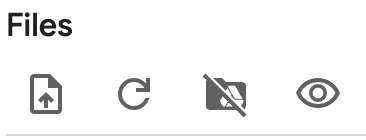



In [132]:
if not os.path.exists('drive/MyDrive/CTME-LLM-labs'):
    !mkdir drive/MyDrive/CTME-LLM-labs
!cp ecommerce.db drive/MyDrive/CTME-LLM-labs/